## Graph Neural Network Property Predictor


## Imports

In [4]:
# Working on segmenting from monolithic structure as this file is getting too lengthy
from model import GNN
from utils.config import FEATURE_NAMES, GRAPH_METRICS, RESIDUAL_G_FEATURES
from utils.visualization import VisualizationManager
import utils.data_utils as DataUtils

## Execution


Data Processing Debug:
Number of nodes: 100
Number of features: 45
Feature tensor shape: torch.Size([100, 45])
Edge index shape: torch.Size([2, 268])
Target value: 1.0
Selected nodes: [np.int64(65), 55, 20, 25]

Data Processing Debug:
Number of nodes: 100
Number of features: 45
Feature tensor shape: torch.Size([100, 45])
Edge index shape: torch.Size([2, 269])
Target value: 1.0
Selected nodes: [np.int64(56), 7, 9, 16]
Epoch   0: Train Loss = 2.3493, Test Loss = 0.9938
Epoch   5: Train Loss = 1.8128, Test Loss = 0.9215
Epoch  10: Train Loss = 1.5940, Test Loss = 0.8753
Epoch  15: Train Loss = 1.6752, Test Loss = 0.8485
Epoch  20: Train Loss = 1.2907, Test Loss = 0.8131
Epoch  25: Train Loss = 1.4088, Test Loss = 0.7929
Epoch  30: Train Loss = 0.9199, Test Loss = 0.7565
Epoch  35: Train Loss = 0.8262, Test Loss = 0.7367
Epoch  40: Train Loss = 0.7742, Test Loss = 0.7221
Epoch  45: Train Loss = 0.7014, Test Loss = 0.7385
Epoch  50: Train Loss = 0.5781, Test Loss = 0.7987
Epoch  55: Train 

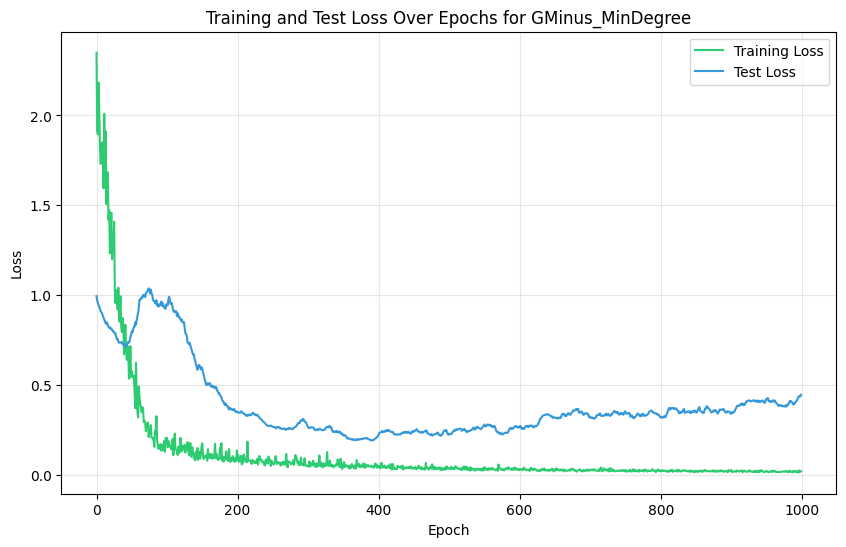


Final Test Metrics:
test_loss: 0.4453
mae: 0.3859
r2_score: -inf


In [5]:
# Generate different graphs for training and test to test generalization
G_train, selected_nodes_train = DataUtils.generate_graph(num_nodes=100, edge_prob=0.05)
G_test, selected_nodes_test = DataUtils.generate_graph(num_nodes=100, edge_prob=0.05)

# Select target feature for analysis.
target_feature = "GMinus_MinDegree"

# Make sure the user only selects a feature in P(G/G')
if target_feature not in RESIDUAL_G_FEATURES:
    raise ValueError(
        f"Invalid target feature: {target_feature}\n"
        f"Target feature must be one of the following G/G' metrics:\n"
        f"{', '.join(RESIDUAL_G_FEATURES)}"
    )

target_idx = RESIDUAL_G_FEATURES.index(target_feature)

train_data = DataUtils.process_graph_data(G_train, selected_nodes_train, target_idx)
test_data = DataUtils.process_graph_data(G_test, selected_nodes_test, target_idx)

model = GNN(node_feature_dim=len(FEATURE_NAMES)-1)

losses, trained_model = model.train_model(
    model, 
    train_data=train_data,
    test_data=test_data, 
    target_idx=target_idx
)

# Plot training progress
vis = VisualizationManager()
vis.plot_training_progress(
    train_losses=[loss['train_loss'] for loss in losses],
    test_losses=[loss['test_loss'] for loss in losses],
    title="Training and Test Loss Over Epochs for " + target_feature
)

# Get final test metrics
test_metrics = trained_model.evaluate(test_data, target_idx)
print("\nFinal Test Metrics:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")